Random Forests are not typically optimized using gradient descent like neural networks or linear models. However, we can regularize them by controlling model complexity. Some regularization-like parameters in Random Forest include:

    max_depth – limits the depth of each tree.

    min_samples_split / min_samples_leaf – ensures each split has a minimum number of samples.

    max_features – limits the number of features considered at each split.

    n_estimators – more trees reduce variance but increase computational cost.

    bootstrap=False – using the whole dataset rather than bootstrapped samples can reduce variance.

# needs: pip install scikit-optimize


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

In [2]:
# 1. Generate synthetic dataset
np.random.seed(42)
n_samples = 1000

# Simulated features (soil, weather, fertilizer, etc.)
X = pd.DataFrame({
    'soil_carbon': np.random.rand(n_samples),
    'rainfall': np.random.rand(n_samples) * 100,
    'fertilizer_amount': np.random.rand(n_samples) * 50,
    'crop_yield': np.random.rand(n_samples) * 10
})

# Add some missing values
X.loc[X.sample(frac=0.1).index, 'rainfall'] = np.nan
X.loc[X.sample(frac=0.05).index, 'fertilizer_amount'] = np.nan

# Target variable: simulated GHG emissions (kg CO₂-eq/ha)
y = (
    10 + 5 * X['soil_carbon'] +
    0.2 * X['rainfall'].fillna(50) +
    0.8 * X['fertilizer_amount'].fillna(25) +
    0.1 * X['crop_yield'] +
    np.random.normal(0, 2, n_samples)
)

In [3]:
# 2. Preprocessing
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [4]:
# 3. Parameter space
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'max_features': ['auto', 'sqrt']
}
param_dist = {
    'n_estimators': randint(100, 201),
    'max_depth': [5, 10, None],
    'max_features': ['auto', 'sqrt']
}
param_bayes = {
    'n_estimators': Integer(100, 200),
    'max_depth': Categorical([5, 10, None]),
    'max_features': Categorical(['auto', 'sqrt'])
}

In [5]:
# 4. Results dictionary
results = {}

In [6]:
# 5. GridSearchCV
grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid,
                    cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)
y_pred_grid = grid.predict(X_test)
results["GridSearchCV"] = {
    'MSE': mean_squared_error(y_test, y_pred_grid),
    'R2': r2_score(y_test, y_pred_grid)
}

In [7]:
# 6. RandomizedSearchCV
random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=6,  # total number of combinations in GridSearch
                                   cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
y_pred_rand = random_search.predict(X_test)
results["RandomizedSearchCV"] = {
    'MSE': mean_squared_error(y_test, y_pred_rand),
    'R2': r2_score(y_test, y_pred_rand)
}

In [8]:

# 7. BayesSearchCV
bayes_search = BayesSearchCV(
    RandomForestRegressor(random_state=42),
    search_spaces=param_bayes,
    n_iter=6,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
bayes_search.fit(X_train, y_train)
y_pred_bayes = bayes_search.predict(X_test)
results["BayesSearchCV"] = {
    'MSE': mean_squared_error(y_test, y_pred_bayes),
    'R2': r2_score(y_test, y_pred_bayes)
}

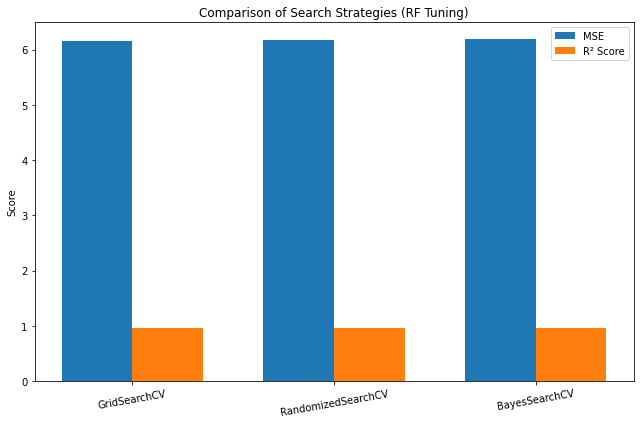

In [9]:
# 8. Plotting
labels = list(results.keys())
mse_vals = [results[k]['MSE'] for k in labels]
r2_vals = [results[k]['R2'] for k in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(9,6))
plt.bar(x - width/2, mse_vals, width, label='MSE')
plt.bar(x + width/2, r2_vals, width, label='R² Score')
plt.xticks(x, labels, rotation=10)
plt.ylabel("Score")
plt.title("Comparison of Search Strategies (RF Tuning)")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# 9. Print results
for k, v in results.items():
    print(f"{k}: MSE = {v['MSE']:.4f}, R² = {v['R2']:.4f}")

GridSearchCV: MSE = 6.1558, R² = 0.9661
RandomizedSearchCV: MSE = 6.1672, R² = 0.9661
BayesSearchCV: MSE = 6.1853, R² = 0.9660
